In [1]:
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/My Drive/fire_data.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as onp
import jax.numpy as np
import pandas as pd
from jax import random, grad, jit, vmap
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
fire_data = pd.read_csv(filename)

In [4]:
N_rd = 1000
N_in = 100
N_inv = 647

key_x_rd = random.PRNGKey(0)
key_y_rd = random.PRNGKey(1)
key_t_rd = random.PRNGKey(2)
key_x_in = random.PRNGKey(3)
key_y_in = random.PRNGKey(4)

config.update("jax_enable_x64", True)

xyt_rd = np.concatenate((2*random.uniform(key_x_rd, (N_rd,1))-1, 2*random.uniform(key_y_rd, (N_rd,1))-1, random.uniform(key_t_rd, (N_rd,1),maxval = 3)), axis = 1)
xyt_in = np.concatenate((2*random.uniform(key_x_in, (N_in,1))-1, 2*random.uniform(key_y_in, (N_in,1))-1, np.zeros((N_in,1))), axis = 1)
xyt_inv = np.asarray(fire_data)
xyt_dd = xyt_in

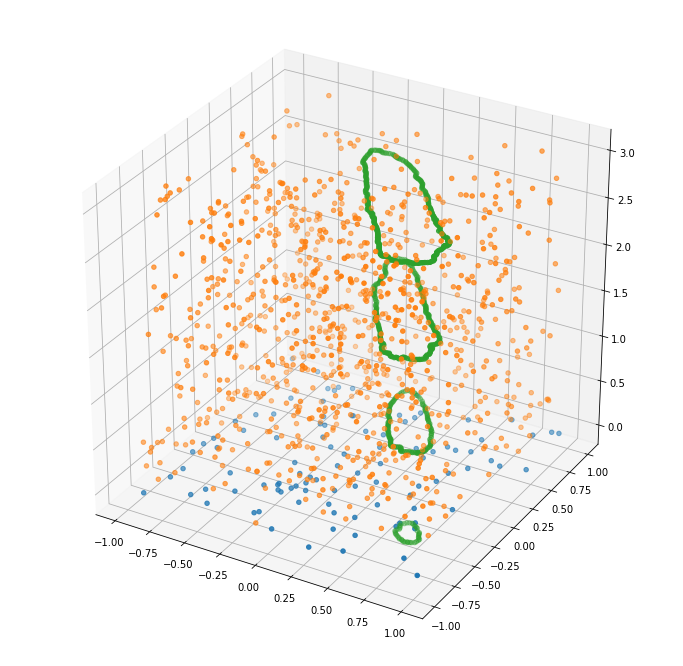

In [5]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xyt_dd[:,0], xyt_dd[:,1], xyt_dd[:,2])
ax.scatter(xyt_rd[:,0], xyt_rd[:,1], xyt_rd[:,2])
ax.scatter(xyt_inv[:,0], xyt_inv[:,1], xyt_inv[:,2])
plt.show()


In [6]:
k = 0.2
x0 = 0.732
y0 = -0.57
u_st = lambda x,y: np.sqrt((x-x0)**2 + (y-y0)**2) - k

u_rd = np.zeros((N_rd,1))
u_dd = u_st(xyt_dd[:,0], xyt_dd[:,1])

In [7]:
key_x_tt = random.PRNGKey(5)
key_y_tt = random.PRNGKey(6)

N_tt     = 10000
xyt_test  = np.concatenate((2*random.uniform(key_x_tt, (N_tt,1))-1, 2*random.uniform(key_y_tt, (N_tt,1))-1, np.zeros((N_tt,1))), axis = 1)
u_test = u_st(xyt_test[:,0], xyt_test[:,1])

In [8]:
class DataGenerator(data.Dataset):
  def __init__(self, xyt, u, batch_size = 64, rng_key = random.PRNGKey(1234)):
    'Initialization'
    self.xyt = xyt
    self.u = u

    self.N = u.shape[0]
    self.batch_size = batch_size
    self.key = rng_key
  
  def __getitem__(self,index):
    'Generate one batch of data'
    self.key, subkey = random.split(self.key)
    inputs, outputs = self.__data_generation(subkey)
    return inputs, outputs
  
  @partial(jit, static_argnums = (0,))
  def __data_generation(self,key):
    'Generates data containing batch_size samples'
    idx = random.choice(key, self.N, (self.batch_size,), replace = False)
    xyt = self.xyt[idx, :] 
    u = self.u[idx,:]
    inputs = xyt
    outputs = u
    return inputs, outputs

In [9]:
def MLP(layers, activation=relu):
  def init(rng_key):
    def init_layer(key, d_in, d_out):
      k1, k2 = random.split(key)
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(k1, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b
    key, *keys = random.split(rng_key, len(layers))
    params = list(map(init_layer, keys, layers[:-1], layers[1:]))
    return params
  def apply(params, inputs):
    for W, b in params[:1]:
      outputs = np.dot(inputs, W) + b
      inputs = activation(outputs)
    W, b = params[-1]
    outputs = np.dot(inputs, W) + b
    return outputs
  return init, apply

In [10]:
class PINNs:
  def __init__(self, PINN_layers):
    # Network initialization and evaluation functions
    self.PINN_init, self.PINN_apply = MLP(PINN_layers, activation=np.tanh)
    
    # Initialize
    params = self.PINN_init(rng_key = random.PRNGKey(1234))

    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.9))

    self.opt_state = self.opt_init(params)

    self.itercount = itertools.count()

    self.loss_log = []
    self.loss_data_log = []
    self.loss_physics_log = []
    self.loss_inv_log = []

  def PINN_net(self, params, x, y, t):
    inputs = np.stack((x,y,t))
    outputs = self.PINN_apply(params, inputs)[0]
    return outputs

  def residual_net(self, params, x, y, t):
    s = 0.4
    wx = -0.1
    wy = 0.1
    u_t = grad(self.PINN_net, argnums=3)(params, x, y, t)
    du = grad(self.PINN_net, argnums=(1,2,3))(params, x, y, t)
    du_norm = np.linalg.norm(np.array(du))
    res = u_t + s * du_norm + np.dot(np.array((wx,wy,0.)), np.array(du))
    return res

  def loss_data(self, params, batch):
    inputs, outputs = batch
    pred = vmap(self.PINN_net, (None, 0, 0, 0))(params, inputs[:,0], inputs[:,1], inputs[:,2])
    loss = np.mean((outputs.flatten() - pred.flatten())**2)
    return loss
  
  def loss_physics(self, params, batch):
    inputs, outputs = batch
    pred = vmap(self.residual_net, (None, 0, 0, 0))(params, inputs[:,0], inputs[:,1], inputs[:,2])
    loss = np.mean((outputs.flatten() - pred.flatten())**2)
    return loss

  def loss_inv(self, params, batch):
    inputs, outputs = batch
    pred = vmap(self.PINN_net, (None, 0, 0, 0))(params, inputs[:,0], inputs[:,1], inputs[:,2])
    loss = np.mean((outputs.flatten() - pred.flatten())**2)
    return loss
  
  def loss(self, params, data_batch, physics_batch, inv_batch):
    loss_data = self.loss_data(params, data_batch)
    loss_physics = self.loss_physics(params, physics_batch)
    loss_inv = self.loss_inv(params, inv_batch)
    loss = loss_data + loss_physics + loss_inv
    return loss

  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, data_batch, physics_batch, inv_batch):
    params = self.get_params(opt_state)
    g = grad(self.loss)(params, data_batch, physics_batch, inv_batch)
    return self.opt_update(i, g, opt_state)
  
  def train(self, data_dataset, physics_dataset, inv_dataset, nIter = 10000):
    data_data = iter(data_dataset)
    physics_data = iter(physics_dataset)
    inv_data = iter(inv_dataset)

    pbar = trange(nIter)

    loss_min = 1e+8

    for it in pbar:
      data_batch = next(data_data)
      physics_batch = next(physics_data)
      inv_batch = next(inv_data)

      self.opt_state = self.step(next(self.itercount), self.opt_state, data_batch, physics_batch, inv_batch)

      if it % 100 == 0:
        params = self.get_params(self.opt_state)

        loss_value = self.loss(params, data_batch, physics_batch, inv_batch)
        loss_data_value = self.loss_data(params, data_batch)
        loss_physics_value = self.loss_physics(params, physics_batch)
        loss_inv_value = self.loss_inv(params, inv_batch)

        self.loss_log.append(loss_value)
        self.loss_data_log.append(loss_data_value)
        self.loss_physics_log.append(loss_physics_value)
        self.loss_inv_log.append(loss_inv_value)

        if loss_min > loss_value:
          loss_min = loss_value
          opt_param = params

        pbar.set_postfix({
           'loss' : loss_value,
           'loss_data' : loss_data_value,
           'loss_physics' : loss_physics_value,
           'loss_inv' : loss_inv_value
        })
    return opt_param

  @partial(jit, static_argnums=(0,))
  def predict_PINN(self, params, x_star, y_star, t_star):
    PINN_pred = vmap(self.PINN_net, (None,0,0,0))(params, x_star, y_star, t_star)
    return PINN_pred

In [11]:
NN_layers = [3, 64, 64, 1]
model = PINNs(NN_layers)

In [12]:
batch_size = 1000
data_batch_size = N_in
inv_batch_size = 200
physics_dataset = DataGenerator(xyt_rd, u_rd[:,None], batch_size)
data_dataset = DataGenerator(xyt_dd, u_dd[:,None], data_batch_size)
inv_dataset = DataGenerator(xyt_inv, np.zeros((N_inv,1)), inv_batch_size)

In [13]:
# Train
maxiter = 40000
opt_param = model.train(data_dataset, physics_dataset, inv_dataset, nIter=maxiter)

100%|██████████| 40000/40000 [04:59<00:00, 133.77it/s, loss=0.0011095791275863973, loss_data=0.000752865018106357, loss_physics=0.00029975789216538334, loss_inv=5.6956217314656865e-05]


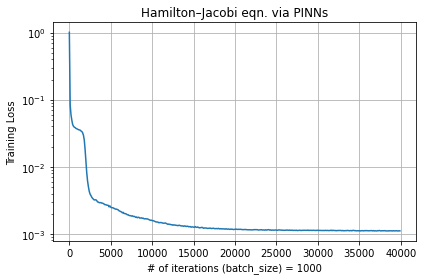

In [14]:
loss_vec = model.loss_log
intv = np.arange(0, maxiter, 100)
plt.figure
plt.semilogy(intv, loss_vec, label='Loss')
plt.xlabel('# of iterations (batch_size) = 1000')
plt.ylabel('Training Loss')
plt.title('Hamilton–Jacobi eqn. via PINNs')
plt.tight_layout()
plt.grid()

In [15]:
PINN_pred = model.predict_PINN(opt_param, xyt_test[:,0], xyt_test[:,1], xyt_test[:,2])[:,None]

In [16]:
rel_l2_error = np.linalg.norm(u_test[:,None] - PINN_pred) / np.linalg.norm(u_test[:,None])
print('Relative L2 Error of the PINN = {:.4e}'.format(rel_l2_error))

Relative L2 Error of the PINN = 2.8811e-02


In [17]:
x_graph = np.linspace(-1,1,100)
y_graph = np.linspace(-1,1,100)

X_g, Y_g = np.meshgrid(x_graph, y_graph)


In [18]:
xy_graph = np.concatenate((X_g.reshape((100**2, 1)), Y_g.reshape((100**2, 1))), axis=1)
t_graph = np.ones(10000)
PINN_graph1 = model.predict_PINN(opt_param, xy_graph[:,0], xy_graph[:,1], t_graph*0)
PINN_graph2 = model.predict_PINN(opt_param, xy_graph[:,0], xy_graph[:,1], t_graph*1)
PINN_graph3 = model.predict_PINN(opt_param, xy_graph[:,0], xy_graph[:,1], t_graph*2)
PINN_graph4 = model.predict_PINN(opt_param, xy_graph[:,0], xy_graph[:,1], t_graph*3)

p1 = np.where((0<PINN_graph1), PINN_graph1, 0)
p2 = np.where((0<PINN_graph2), PINN_graph2, 0)
p3 = np.where((0<PINN_graph3), PINN_graph3, 0)
p4 = np.where((0<PINN_graph4), PINN_graph4, 0)


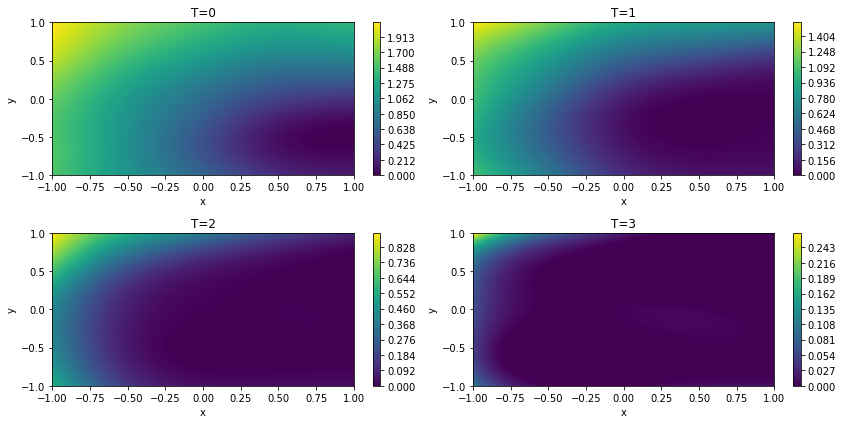

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.tricontourf(xy_graph[:,0], xy_graph[:,1], p1,levels=1000)
plt.colorbar(extend='both')
plt.xlabel('x')
plt.ylabel('y')
plt.title('T=0')
plt.tight_layout()

plt.subplot(2,2,2)
plt.tricontourf(xy_graph[:,0], xy_graph[:,1], p2,levels=1000)
plt.colorbar(extend='both')
plt.xlabel('x')
plt.ylabel('y')
plt.title('T=1')
plt.tight_layout()

plt.subplot(2,2,3)
plt.tricontourf(xy_graph[:,0], xy_graph[:,1], p3, levels=1000)
plt.colorbar(extend='both')
plt.xlabel('x')
plt.ylabel('y')
plt.title('T=2')
plt.tight_layout()

plt.subplot(2,2,4)
plt.tricontourf(xy_graph[:,0], xy_graph[:,1], p4, levels=1000)
plt.colorbar(extend='both')
plt.xlabel('x')
plt.ylabel('y')
plt.title('T=3')
plt.tight_layout()

plt.show()